In [1]:
####
# Creator;Maintainer: Tamas Szuromi - tromika@gmail.com
####

In [59]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [133]:
data = pd.read_csv("../data/raw/training.csv")

In [3]:
data.columns.values

array(['order_id', 'contact_id', 'purchase_date', 'product_id', 'quantity',
       'sales_amount'], dtype=object)

In [26]:
data.dtypes

order_id                  int64
contact_id                int64
purchase_date    datetime64[ns]
product_id                int64
quantity                  int64
sales_amount            float64
dtype: object

In [134]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [27]:
data.head()

,order_id,contact_id,purchase_date,product_id,quantity,sales_amount
0,4852169,17846335,2012-01-01,3308032,1,18.71
1,3570597,18759585,2012-01-01,37220513,2,83.50
2,32096674,5025194,2012-01-01,10259603,1,19.95
3,2904402,29624779,2012-01-01,3308032,1,18.71
4,38369470,42287117,2012-01-01,3308032,1,18.71


In [135]:
dataFiltered = data[(data.sales_amount>0) & (data.sales_amount<=np.percentile(data['sales_amount'],[99.995])[0]) & (data.quantity<=np.percentile(data['quantity'],[99.99])[0]) ]
inputData = dataFiltered.groupby(['contact_id', 'order_id']).agg({'sales_amount': np.sum, 'purchase_date':'first'}).reset_index()

In [94]:
inputData.head()

,contact_id,order_id,purchase_date,sales_amount
0,22,20931901,2012-01-03,27.45
1,445,36058004,2012-11-22,131.85
2,665,15515069,2013-06-06,309.47
3,734,30699049,2013-05-07,69.90
4,884,2789595,2013-03-21,254.85


In [205]:
trainingSet = summary_data_from_transaction_data(inputData, 'contact_id', 'purchase_date', monetary_value_col= 'sales_amount', freq='M',observation_period_end='2013-12-31')

In [31]:
trainingSet.columns.values

array(['frequency', 'recency', 'T', 'monetary_value'], dtype=object)

In [233]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(trainingSet['frequency'], trainingSet['recency'], trainingSet['T'])
print bgf

<lifetimes.ModifiedBetaGeoFitter: fitted with 262264 subjects, a: 0.81, alpha: 7.20, b: 0.68, r: 0.59>


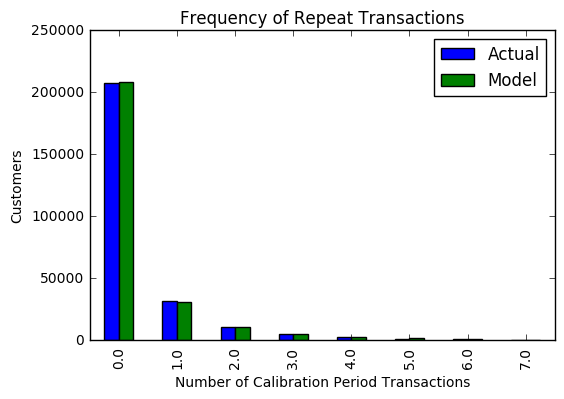

In [146]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

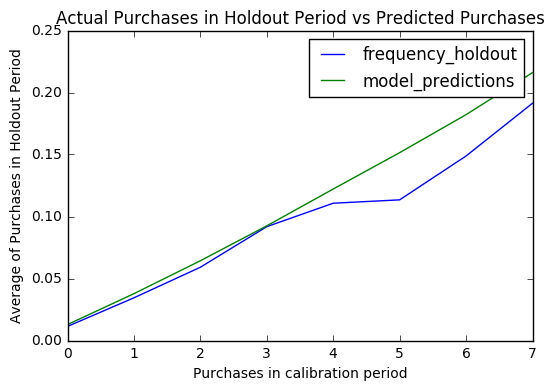

In [237]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(data, 'contact_id', 'purchase_date', 
                                        calibration_period_end='2013-11-30',
                                        observation_period_end='2013-12-31', 
                                        freq='M' )   
bgfVal = ModifiedBetaGeoFitter(penalizer_coef=0.0001)
bgfVal.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgfVal, summary_cal_holdout)

In [234]:
from lifetimes import GammaGammaFitter

ReturningtTrainingSet = trainingSet[trainingSet['frequency']>0]
ggf = GammaGammaFitter(penalizer_coef=0.0001)
ggf.fit(ReturningtTrainingSet['frequency'],
        ReturningtTrainingSet['monetary_value'])
print ggf  

<lifetimes.GammaGammaFitter: fitted with 49154 subjects, p: 8.00, q: 1.87, v: 11.86>


In [235]:
print "Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        trainingSet['frequency'],
        trainingSet['monetary_value']
    ).mean(),
    trainingSet['monetary_value'].mean()
)

Expected conditional average profit: 106.545329023, Average profit: 17.8773260528


In [228]:
pred = bgf.conditional_expected_number_of_purchases_up_to_time(1,
    trainingSet['frequency'],
    trainingSet['recency'],
    trainingSet['T'])

In [236]:
pred2.sum()*106+741310

1359798.3125790888